# Varying noisy data amount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#all required import statements
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

In [ ]:
#Load
import numpy as np

save_path = '/content/drive/MyDrive/GSMP2/processed_data.npz'
data = np.load(save_path)

# Extracting the datasets
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']

In [ ]:
varying_noisy_data_amount = "add the precent you want to try with"


''' we have tried with 15% , 20%, and 30% '''

In [ ]:
def preprocess_image(image, scale_percent=20, noise_factor=0.15):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    width = int(small_image.shape[1] * (100 / scale_percent))
    height = int(small_image.shape[0] * (100 / scale_percent))
    dim = (width, height)
    pixelated_image = cv2.resize(small_image, dim, interpolation=cv2.INTER_LINEAR)
    noisy_image = pixelated_image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=pixelated_image.shape)
    noisy_image = np.clip(noisy_image, 0., 255.).astype(np.uint8)
    return noisy_image

In [ ]:
def preprocess_dataset(images, scale_percent=20, noise_factor=0.15):
    return np.array([preprocess_image(img, scale_percent, noise_factor) for img in images])

15% Noise data

In [ ]:
# Apply preprocessing to a subset of the data
indices_to_preprocess = np.random.choice(range(x_train.shape[0]), size=int(varying_noisy_data_amount * x_train.shape[0]), replace=False)
x_train_preprocessed = x_train.copy()
x_train_preprocessed[indices_to_preprocess] = preprocess_dataset(x_train[indices_to_preprocess])


In [ ]:
indices_to_preprocess = np.random.choice(range(x_val.shape[0]), size=int(varying_noisy_data_amount * x_val.shape[0]), replace=False)
x_val_preprocessed = x_val.copy()
x_val_preprocessed[indices_to_preprocess] = preprocess_dataset(x_val[indices_to_preprocess])


In [ ]:
x_train_preprocessed.shape

(4569, 200, 200, 3)

In [ ]:
x_val_preprocessed.shape

(1143, 200, 200, 3)

In [ ]:
assert x_train.shape[0] == x_train_preprocessed.shape[0]
assert x_val.shape[0] == x_val_preprocessed.shape[0]

In [ ]:
def denoise_and_deblur_images(input_images, deblur_model_path, denoise_model_path):
    autoencoder_deblur = load_model(deblur_model_path)
    autoencoder_denoise = load_model(denoise_model_path)
    denoised_images = autoencoder_denoise.predict(input_images)
    deblurred_images = autoencoder_deblur.predict(denoised_images)
    return deblurred_images

In [ ]:
from keras.models import load_model


In [ ]:
# Apply denoising and deblurring
x_train_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_train_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)

x_val_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_val_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


36/36 [==============================] - 7s 188ms/step


In [ ]:
x_train_preprocessed_denoised_deblurred.shape

(4569, 200, 200, 3)

In [ ]:
# Initialize and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [ ]:
history = model.fit(
    x_train_preprocessed_denoised_deblurred, y_train,
    batch_size = 20,
    validation_data=(x_val_preprocessed_denoised_deblurred, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7608
Epoch 1: val_accuracy improved from -inf to 0.22047, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 47s 89ms/step - loss: 0.5743 - accuracy: 0.7608 - val_loss: 1.4390 - val_accuracy: 0.2205 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.3584 - accuracy: 0.8423
Epoch 2: val_accuracy improved from 0.22047 to 0.27822, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.3586 - accuracy: 0.8424 - val_loss: 1.3178 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 3/50
228/229 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8735
Epoch 3: val_accuracy improved from 0.27822 to 0.42432, saving model to best_model.h5
229/229 [==============================] - 18s 78ms/step - loss: 0.2654 - accuracy: 0.8737 - val_loss: 1.4321 - val_accuracy: 0.4243 - lr: 1.0000e-04
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 0.2786 - accuracy: 0.8673
Epoch 4: val_accuracy improved from 0.42432 to 0.58268, saving model to best_model.h5
229/

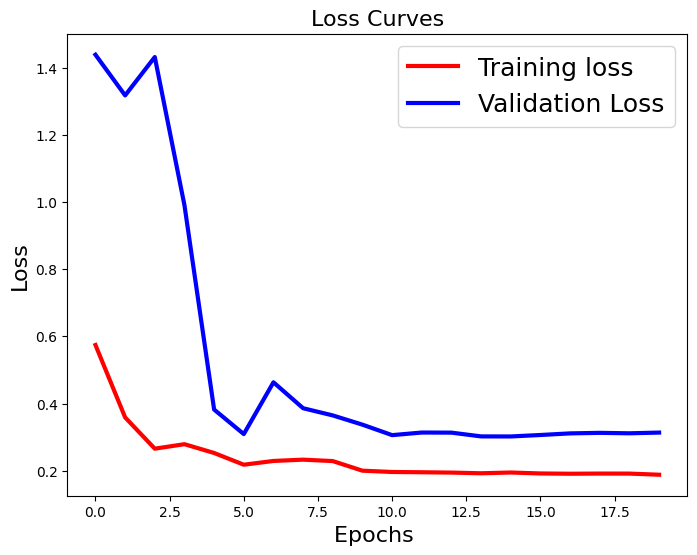

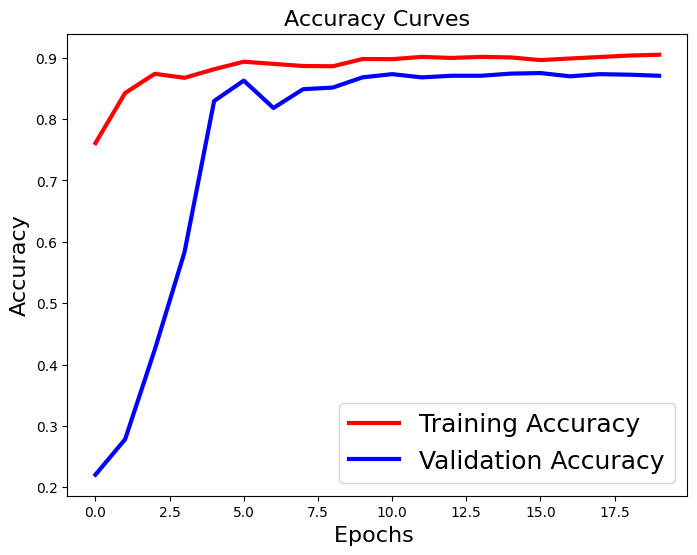

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
indices_to_preprocess = np.random.choice(range(x_test.shape[0]), size=int(varying_noisy_data_amount * x_test.shape[0]), replace=False)
x_test_preprocessed = x_test.copy()
x_test_preprocessed[indices_to_preprocess] = preprocess_dataset(x_test[indices_to_preprocess])


In [ ]:
x_test_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_test_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


41/41 [==============================] - 8s 198ms/step


In [ ]:
loss,acc = model.evaluate(x_test_preprocessed_denoised_deblurred, y_test)


41/41 [==============================] - 1s 33ms/step - loss: 0.1605 - accuracy: 0.9451


without using deblurring and denoising autoencoder

In [ ]:
# Initialize and compile the model
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model1 = Model(inputs=base_model1.input, outputs=predictions)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [ ]:
history1 = model1.fit(
    x_train, y_train,
    batch_size = 20,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
228/229 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.8998
Epoch 1: val_accuracy improved from -inf to 0.27384, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 47s 91ms/step - loss: 0.2774 - accuracy: 0.8998 - val_loss: 2.3404 - val_accuracy: 0.2738 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9770
Epoch 2: val_accuracy did not improve from 0.27384
229/229 [==============================] - 17s 73ms/step - loss: 0.0668 - accuracy: 0.9770 - val_loss: 2.8878 - val_accuracy: 0.2117 - lr: 1.0000e-04
Epoch 3/50
228/229 [============================>.] - ETA: 0s - loss: 0.0447 - accuracy: 0.9855
Epoch 3: val_accuracy improved from 0.27384 to 0.49869, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.0448 - accuracy: 0.9856 - val_loss: 1.7906 - val_accuracy: 0.4987 - lr: 1.0000e-04
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9836
Epoch 4: val_accuracy improved from 0.49869 to 0.60717, saving model to best_model.h5
229/229 [==============================

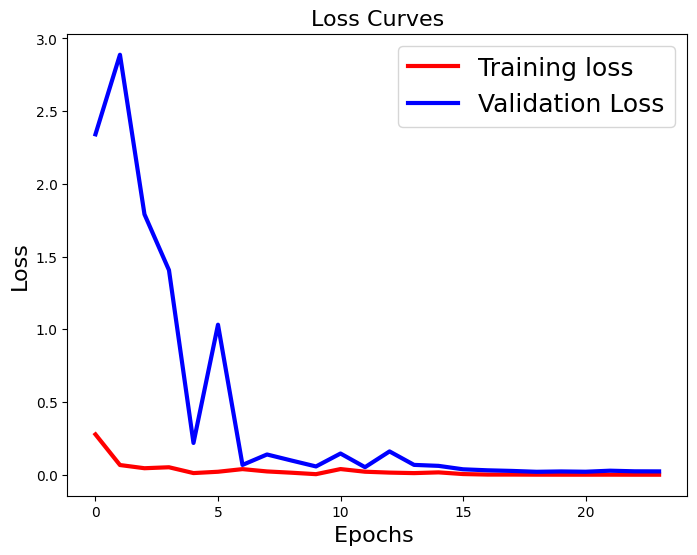

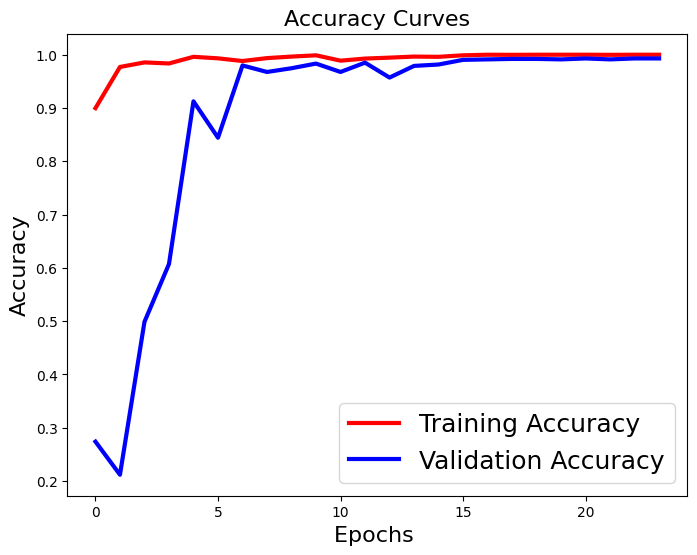

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],'r',linewidth=3.0)
plt.plot(history1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
loss,acc = model1.evaluate(x_test_preprocessed,y_test)


41/41 [==============================] - 1s 32ms/step - loss: 0.6110 - accuracy: 0.8894


20 % noisy data

In [ ]:
# Apply preprocessing to a subset of the data
indices_to_preprocess = np.random.choice(range(x_train.shape[0]), size=int(varying_noisy_data_amount * x_train.shape[0]), replace=False)
x_train_preprocessed = x_train.copy()
x_train_preprocessed[indices_to_preprocess] = preprocess_dataset(x_train[indices_to_preprocess])


In [ ]:
indices_to_preprocess = np.random.choice(range(x_val.shape[0]), size=int(varying_noisy_data_amount * x_val.shape[0]), replace=False)
x_val_preprocessed = x_val.copy()
x_val_preprocessed[indices_to_preprocess] = preprocess_dataset(x_val[indices_to_preprocess])


In [ ]:
# Apply denoising and deblurring
x_train_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_train_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)

x_val_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_val_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


36/36 [==============================] - 3s 82ms/step


In [ ]:
# Initialize and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    x_train_preprocessed_denoised_deblurred, y_train,
    batch_size = 20,
    validation_data=(x_val_preprocessed_denoised_deblurred, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.7238
Epoch 1: val_accuracy improved from -inf to 0.34383, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 52s 95ms/step - loss: 0.6282 - accuracy: 0.7238 - val_loss: 1.3729 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8114
Epoch 2: val_accuracy improved from 0.34383 to 0.37445, saving model to best_model.h5
229/229 [==============================] - 18s 78ms/step - loss: 0.4033 - accuracy: 0.8116 - val_loss: 1.3292 - val_accuracy: 0.3745 - lr: 1.0000e-04
Epoch 3/50
228/229 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8303
Epoch 3: val_accuracy improved from 0.37445 to 0.46632, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.3647 - accuracy: 0.8302 - val_loss: 1.0874 - val_accuracy: 0.4663 - lr: 1.0000e-04
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8450
Epoch 4: val_accuracy did not improve from 0.46632
229/229 [==============================

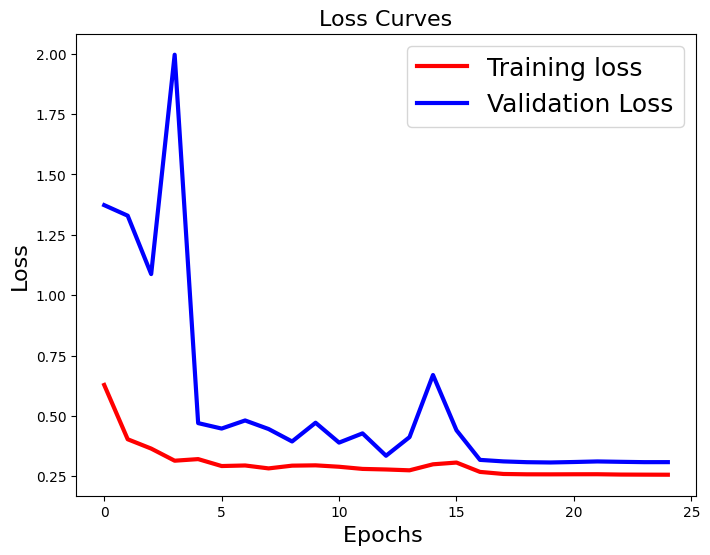

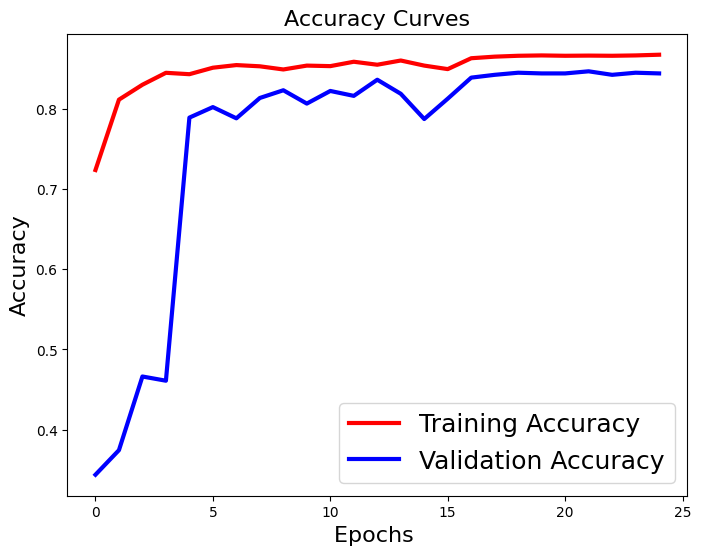

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
indices_to_preprocess = np.random.choice(range(x_test.shape[0]), size=int(varying_noisy_data_amount * x_test.shape[0]), replace=False)
x_test_preprocessed = x_test.copy()
x_test_preprocessed[indices_to_preprocess] = preprocess_dataset(x_test[indices_to_preprocess])

In [ ]:
x_test_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_test_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


41/41 [==============================] - 8s 199ms/step


In [ ]:
loss,acc = model.evaluate(x_test_preprocessed_denoised_deblurred, y_test)


41/41 [==============================] - 2s 47ms/step - loss: 0.3533 - accuracy: 0.8360


without using autoencoder model

In [ ]:
# Initialize and compile the model
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model1 = Model(inputs=base_model1.input, outputs=predictions)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]



In [ ]:
history1 = model1.fit(
    x_train, y_train,
    batch_size = 20,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
228/229 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.9066
Epoch 1: val_accuracy improved from -inf to 0.40420, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 91ms/step - loss: 0.2748 - accuracy: 0.9068 - val_loss: 1.5684 - val_accuracy: 0.4042 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9708
Epoch 2: val_accuracy did not improve from 0.40420
229/229 [==============================] - 17s 74ms/step - loss: 0.0865 - accuracy: 0.9709 - val_loss: 1.8080 - val_accuracy: 0.2905 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9891
Epoch 3: val_accuracy improved from 0.40420 to 0.55468, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 1.1013 - val_accuracy: 0.5547 - lr: 1.0000e-04
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9844
Epoch 4: val_accuracy improved from 0.55468 to 0.91426, saving model to best_model.h5
229/229 [==============================

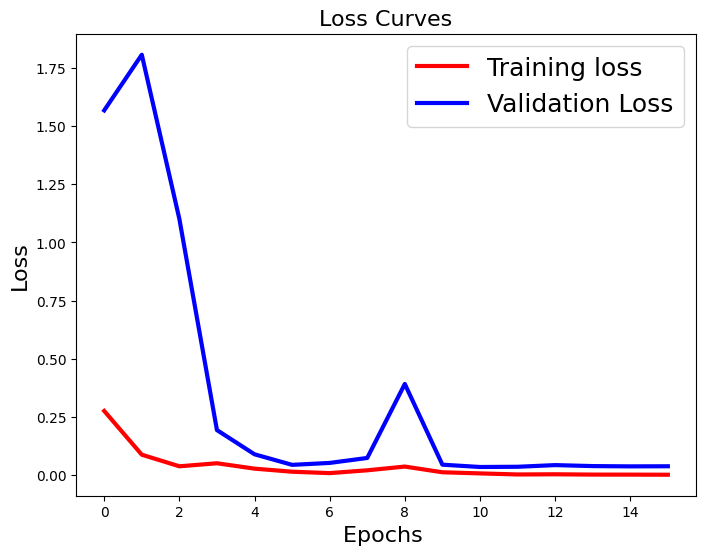

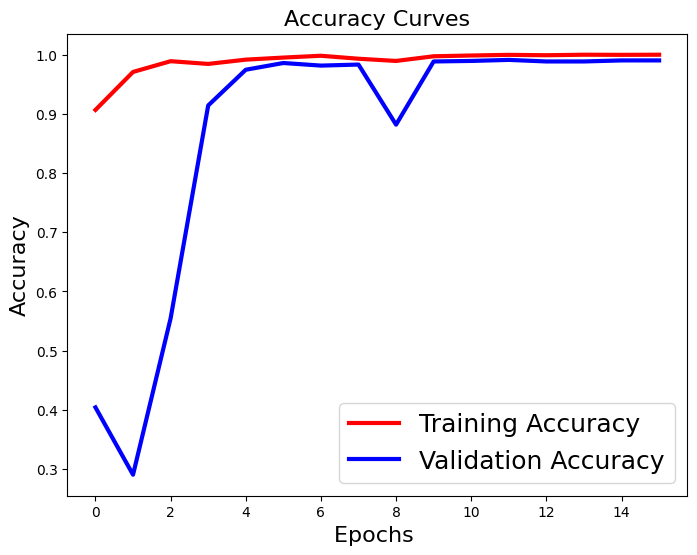

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],'r',linewidth=3.0)
plt.plot(history1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
loss,acc = model1.evaluate(x_test_preprocessed,y_test)


41/41 [==============================] - 1s 32ms/step - loss: 0.9113 - accuracy: 0.8169


30% Noisy Data

In [ ]:
# Apply preprocessing to a subset of the data
indices_to_preprocess = np.random.choice(range(x_train.shape[0]), size=int(0.35 * x_train.shape[0]), replace=False)
x_train_preprocessed = x_train.copy()
x_train_preprocessed[indices_to_preprocess] = preprocess_dataset(x_train[indices_to_preprocess])


In [ ]:
indices_to_preprocess = np.random.choice(range(x_val.shape[0]), size=int(varying_noisy_data_amount * x_val.shape[0]), replace=False)
x_val_preprocessed = x_val.copy()
x_val_preprocessed[indices_to_preprocess] = preprocess_dataset(x_val[indices_to_preprocess])


In [ ]:
# Apply denoising and deblurring
x_train_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_train_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)

x_val_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_val_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


36/36 [==============================] - 7s 187ms/step


In [ ]:
# Initialize and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    x_train_preprocessed_denoised_deblurred, y_train,
    batch_size = 20,
    validation_data=(x_val_preprocessed_denoised_deblurred, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.6632
Epoch 1: val_accuracy improved from -inf to 0.26422, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 52s 94ms/step - loss: 0.7593 - accuracy: 0.6632 - val_loss: 1.3791 - val_accuracy: 0.2642 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.7362
Epoch 2: val_accuracy improved from 0.26422 to 0.27559, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.5286 - accuracy: 0.7365 - val_loss: 1.3931 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 3/50
228/229 [============================>.] - ETA: 0s - loss: 0.4749 - accuracy: 0.7664
Epoch 3: val_accuracy improved from 0.27559 to 0.39545, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.4752 - accuracy: 0.7665 - val_loss: 1.9126 - val_accuracy: 0.3955 - lr: 1.0000e-04
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.7713
Epoch 4: val_accuracy improved from 0.39545 to 0.62467, saving model to best_model.h5
229/

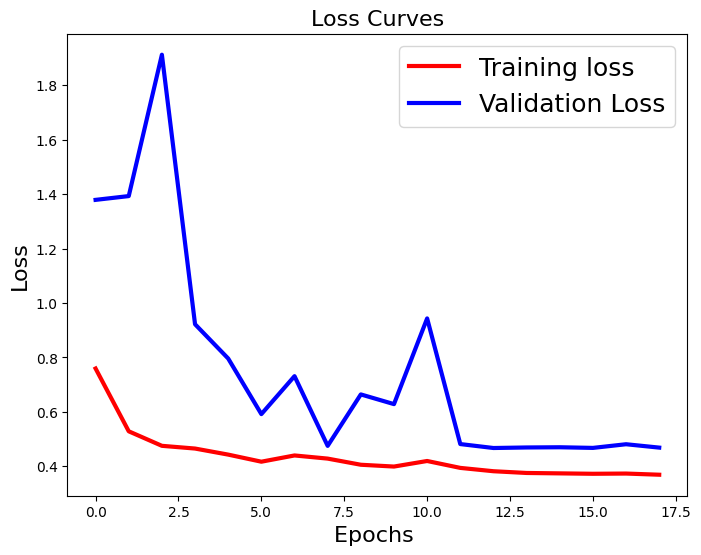

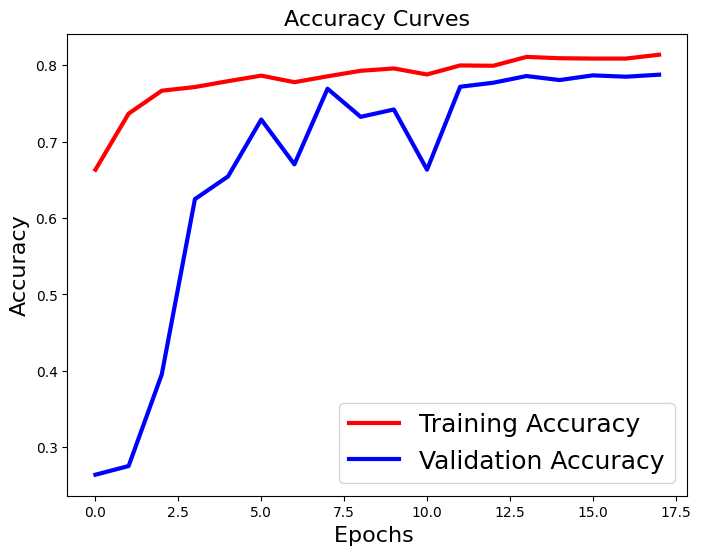

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
indices_to_preprocess = np.random.choice(range(x_test.shape[0]), size=int(varying_noisy_data_amount * x_test.shape[0]), replace=False)
x_test_preprocessed = x_test.copy()
x_test_preprocessed[indices_to_preprocess] = preprocess_dataset(x_test[indices_to_preprocess])

In [ ]:
x_test_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_test_preprocessed,
    "/content/drive/MyDrive/GSMP2/models/deblur_encoder.h5",
    "/content/drive/MyDrive/GSMP2/models/denoise_encoder.h5"
)


41/41 [==============================] - 8s 199ms/step


In [ ]:
loss,acc = model.evaluate(x_test_preprocessed_denoised_deblurred, y_test)


41/41 [==============================] - 3s 47ms/step - loss: 0.5043 - accuracy: 0.7796


Without using the autoencoder model

In [ ]:
# Initialize and compile the model
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)
model1 = Model(inputs=base_model1.input, outputs=predictions)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]



In [ ]:
history1 = model1.fit(
    x_train, y_train,
    batch_size = 20,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
228/229 [============================>.] - ETA: 0s - loss: 0.2628 - accuracy: 0.9037
Epoch 1: val_accuracy improved from -inf to 0.27647, saving model to best_model.h5
229/229 [==============================] - 47s 90ms/step - loss: 0.2631 - accuracy: 0.9037 - val_loss: 7.9888 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9781
Epoch 2: val_accuracy improved from 0.27647 to 0.31496, saving model to best_model.h5
229/229 [==============================] - 18s 79ms/step - loss: 0.0699 - accuracy: 0.9781 - val_loss: 1.4561 - val_accuracy: 0.3150 - lr: 1.0000e-04
Epoch 3/50
228/229 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9836
Epoch 3: val_accuracy improved from 0.31496 to 0.48469, saving model to best_model.h5
229/229 [==============================] - 18s 78ms/step - loss: 0.0548 - accuracy: 0.9834 - val_loss: 1.2720 - val_accuracy: 0.4847 - lr: 1.0000e-04
Epoch 4

In [ ]:
loss,acc = model1.evaluate(x_test_preprocessed,y_test)

41/41 [==============================] - 1s 32ms/step - loss: 1.5298 - accuracy: 0.7307
